In [1]:
import h5py
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [2]:
SEED = 42

In [3]:
file_sc = h5py.File('../data/Scratch-1700591575.7427056-all-embeddings.h5', 'r')
file_bt = h5py.File('../data/Barlow-Twins-F1-3-1701173902.320041-all-embeddings.h5', 'r')

In [4]:
def get_ds_indices(file, samples_pd):
    domains = file['domains']
    indices = np.arange(len(domains))
    indices_pd = {i: np.random.choice(indices[domains[:] == i], samples_pd, replace=False) for i in np.arange(5, dtype=float)}
    
    return sorted(np.concatenate([v for _,v in indices_pd.items()]))

### Check embeddings

In [5]:
indices_sc = get_ds_indices(file_sc, samples_pd=2_000)
indices_bt = get_ds_indices(file_bt, samples_pd=2_000)

X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(file_sc['embeddings'][indices_sc], file_sc['labels'][indices_sc])
X_bt_train, X_bt_test, y_bt_train, y_bt_test = train_test_split(file_bt['embeddings'][indices_bt], file_bt['labels'][indices_bt])

In [16]:
'''
1: Val. OOD
2: Test OOD
'''

domains_sc = file_sc['domains']
indices_sc = np.arange(len(domains_sc))

test_indices = sorted(indices_sc[((domains_sc[:] == 1.0) | (domains_sc[:] == 2.0))])
train_indices = sorted(indices_sc[~((domains_sc[:] == 1.0) | (domains_sc[:] == 2.0))])

X_sc_train, y_sc_train = file_sc['embeddings'][train_indices], file_sc['labels'][train_indices]
X_sc_test, y_sc_test = file_sc['embeddings'][test_indices], file_sc['labels'][test_indices] 

In [17]:
X_sc_train.shape, X_sc_test.shape

((335996, 2048), (119958, 2048))

In [18]:
clf_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(verbose=1)
)
clf_lr.fit(X_sc_train, y_sc_train)
pred = clf_lr.predict(X_sc_test)
print(classification_report(y_sc_test, pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2049     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32895D+05    |proj g|=  7.17825D+04


 This problem is unconstrained.



At iterate   50    f=  1.14803D+03    |proj g|=  6.26633D+01

At iterate  100    f=  4.93016D+02    |proj g|=  2.91688D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    100    117      1     0     0   2.917D+01   4.930D+02
  F =   493.01550725731232     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/yasin/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.2s finished


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     59979
         1.0       1.00      0.98      0.99     59979

    accuracy                           0.99    119958
   macro avg       0.99      0.99      0.99    119958
weighted avg       0.99      0.99      0.99    119958



In [10]:
len(X_sc_train), len(pred)

(7500, 2500)

### UMAP

In [14]:
import umap

In [21]:
reducer = umap.UMAP(n_neighbors=100, n_epochs=1_000, verbose=True)

In [22]:
X_scaled = StandardScaler().fit_transform(X_sc)

In [23]:
X_reduced = reducer.fit_transform(X_scaled)

UMAP(n_epochs=1000, n_neighbors=100, verbose=True)
Tue Nov 28 19:02:56 2023 Construct fuzzy simplicial set
Tue Nov 28 19:02:56 2023 Finding Nearest Neighbors
Tue Nov 28 19:02:56 2023 Building RP forest with 10 trees
Tue Nov 28 19:02:57 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Tue Nov 28 19:03:05 2023 Finished Nearest Neighbor Search
Tue Nov 28 19:03:05 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Nov 28 19:03:25 2023 Finished embedding


In [24]:
X_reduced.shape

(10000, 2)

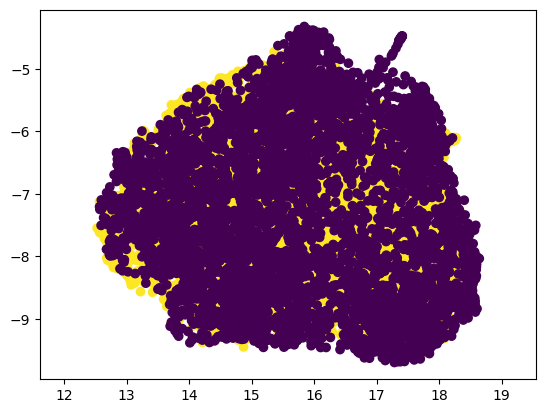

In [25]:
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=file_sc['labels'][indices_bt])
plt.gca().set_aspect('equal', 'datalim')

### T-SNE

In [26]:
from sklearn.decomposition import PCA

In [27]:
# PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_sc)
X_pca.shape

(10000, 100)

In [28]:
from sklearn.manifold import TSNE
from matplotlib import ticker

In [29]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

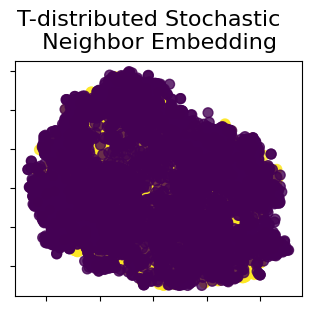

In [31]:
t_sne = TSNE(
    n_components=2,
    perplexity=200,
    init="random",
    n_iter=1_000,
    random_state=0,
    learning_rate='auto',
    metric="euclidean"
)
S_t_sne = t_sne.fit_transform(X_pca)

plot_2d(S_t_sne, file_sc['labels'][indices_bt], "T-distributed Stochastic  \n Neighbor Embedding")

### Logistic Regression

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=SEED, max_iter=10_000, verbose=1)
)

In [23]:
cross_val_score(lr, X_sc, y_sc, cv=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10245     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68229D+04    |proj g|=  3.70756D+02

At iterate   50    f=  1.93151D+04    |proj g|=  3.20984D+02

At iterate  100    f=  1.62533D+04    |proj g|=  3.18418D+02


KeyboardInterrupt: 

In [29]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.44      0.41      0.42       984
         1.0       0.50      0.51      0.50      1008
         2.0       0.52      0.51      0.52      1010
         3.0       0.50      0.50      0.50      1002
         4.0       0.50      0.52      0.51       996

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000



##### Binary

In [24]:
lr_b = make_pipeline(
    scaler, 
    LogisticRegression(random_state=SEED, max_iter=10_000, verbose=1,
                       multi_class="ovr", )
)

In [25]:
lr_b.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2049     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38629D+04    |proj g|=  5.98400D+03

At iterate   50    f=  6.83458D+03    |proj g|=  1.17711D+01

At iterate  100    f=  6.83067D+03    |proj g|=  4.78501D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    132    140      1     0     0   1.409D-01   6.831D+03
  F =   6830.6596119460155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   50    f=  6.30539D+03    |proj g|=  9.96143D+00

At iterate  100    f=  6.30126D+03    |proj g|=  2.86547D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    125    131      1     0     0   5.322D-02   6.301D+03
  F =   6301.2532344132105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2049     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38629D+04    |proj g|=  6.01000D+03


 This problem is unconstrained.



At iterate   50    f=  5.79782D+03    |proj g|=  8.95296D+00

At iterate  100    f=  5.79450D+03    |proj g|=  4.05559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    128    137      1     0     0   1.728D-01   5.794D+03
  F =   5794.4910403424574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2049     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38629D+04    |proj g|=  6.00200D+03


 This problem is unconstrained.



At iterate   50    f=  5.95859D+03    |proj g|=  1.24825D+01

At iterate  100    f=  5.95407D+03    |proj g|=  4.22238D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    137    145      1     0     0   1.281D-01   5.954D+03
  F =   5954.0638390328049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2049     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38629D+04    |proj g|=  5.99600D+03


 This problem is unconstrained.



At iterate   50    f=  6.21959D+03    |proj g|=  1.40154D+01

At iterate  100    f=  6.21542D+03    |proj g|=  8.65345D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2049    133    147      1     0     0   1.324D-01   6.215D+03
  F =   6215.4141656916254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    random_state=42, verbose=1))])

In [26]:
print(classification_report(y_test, lr_b.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.44      0.41      0.43       984
         1.0       0.51      0.53      0.52      1008
         2.0       0.53      0.52      0.52      1010
         3.0       0.49      0.50      0.49      1002
         4.0       0.51      0.53      0.52       996

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



### k-NN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
knn = make_pipeline(
    scaler,
    KNeighborsClassifier(
        n_neighbors=20,
        weights="distance",
        metric="cosine"
    )
)

In [18]:
knn.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='cosine', n_neighbors=20,
                                      weights='distance'))])

In [19]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46       984
         1.0       0.54      0.48      0.51      1008
         2.0       0.56      0.53      0.54      1010
         3.0       0.47      0.57      0.51      1002
         4.0       0.51      0.47      0.49       996

    accuracy                           0.50      5000
   macro avg       0.51      0.50      0.50      5000
weighted avg       0.51      0.50      0.50      5000



### SVM 

In [20]:
from sklearn.svm import SVC

In [21]:
svm = make_pipeline(
    scaler, 
    SVC(
        gamma='auto',
        verbose=1,
        random_state=SEED
    )
)

In [22]:
svm.fit(X_train, y_train)

[LibSVM]......*..*
optimization finished, #iter = 8896
obj = -3753.703497, rho = -0.503879
nSV = 7108, nBSV = 3982
......*..*
optimization finished, #iter = 8706
obj = -3602.427911, rho = -0.340977
nSV = 6904, nBSV = 3729
......*..*
optimization finished, #iter = 8754
obj = -3926.758203, rho = -0.024572
nSV = 7252, nBSV = 4174
......*..*
optimization finished, #iter = 8525
obj = -3890.490080, rho = -0.436013
nSV = 7160, nBSV = 4140
......*..*
optimization finished, #iter = 8645
obj = -3341.289231, rho = 0.153269
nSV = 6657, nBSV = 3519
......*..*
optimization finished, #iter = 8697
obj = -3633.677768, rho = 0.580606
nSV = 6923, nBSV = 3920
......*..*
optimization finished, #iter = 8739
obj = -3649.357154, rho = 0.143054
nSV = 6927, nBSV = 3883
......*...*
optimization finished, #iter = 9045
obj = -3241.375244, rho = 0.366002
nSV = 6630, nBSV = 3277
......*..*
optimization finished, #iter = 8469
obj = -3782.299833, rho = -0.013008
nSV = 7015, nBSV = 4058
......*...*
optimization finishe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=42, verbose=1))])

In [23]:
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53       984
         1.0       0.61      0.62      0.62      1008
         2.0       0.62      0.63      0.62      1010
         3.0       0.60      0.57      0.59      1002
         4.0       0.59      0.59      0.59       996

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000

